In [1]:
import torch
from torch.nn.functional import pad
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
from tqdm.notebook import tqdm

In [3]:
from models.model import CustomModel
from models.model import CRFModel

In [4]:
from datasets import load_from_disk

In [5]:
import tokenmonster

In [6]:
tokenizer_file = "english-8000-balanced-v1"

In [7]:
vocab = tokenmonster.load_multiprocess_safe(tokenizer_file)

In [8]:
initial_vocab_size = len(vocab)

In [9]:
# initial_vocab_size is 8000, so largest valid index is 7999

In [10]:
pad_idx = initial_vocab_size # max valid index is now 8000
eos_idx = initial_vocab_size + 1 # max valid index is now 8001

In [11]:
vocab_size = initial_vocab_size + 2

In [12]:
question_len = 256
context_len = 512
answer_len = 100
assert context_len >= answer_len

In [13]:
embedding_dim = 512
num_heads = 8
target_len = answer_len
num_helix_layers = 1
num_single_strand_layers = 1
phm_factor = 4
lm_head_phm_factor = 2
beam = 32
low_rank = 16
batch_size = 52
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
print(f"Using device: {device}")

Using device: cuda


In [15]:
checkpoint_dir = "checkpoints"

In [16]:
path = f"{checkpoint_dir}/crf_model_newloss.pt"

In [17]:
squad_train_file = "data/squad_train"
dolly_test_file = "data/closed"

In [18]:
squad = load_from_disk(squad_train_file)
dolly = load_from_disk(dolly_test_file)

In [19]:
def collate_fn(batch, question_key, context_key, answer_key):
    """
    Each batch has 3 elements: instruction, context, response
    However since their lengths may vary, we need to pad them.

    For response, must ensure that we add eos token and then begin padding.
    """
    questions = []
    contexts = []
    answers = []

    for elem in batch:
        i = elem[question_key]
        c = elem[context_key]
        r = elem[answer_key]

        questions.append(i)
        contexts.append(c)
        answers.append(r)

    # Pad instructions to question_len
    questions = [pad(i, (0, question_len - len(i)), value=pad_idx) for i in questions]

    # Pad contexts to context_len
    contexts = [pad(c, (0, context_len - len(c)), value=pad_idx) for c in contexts]

    # Pad responses to answer_len
    # though first making sure that eos token is added to end of each response
    eos_append = torch.tensor([eos_idx])
    answers = [torch.cat((r[:answer_len-1], eos_append)) for r in answers]
    answers = [pad(r, (0, answer_len - len(r)), value=pad_idx) for r in answers]

    return torch.stack(questions), torch.stack(contexts), torch.stack(answers)

In [20]:
def dolly_collate_fn(batch):
    return collate_fn(batch, "instruction", "context", "response")

In [21]:
def squad_collate_fn(batch):
    return collate_fn(batch, "question", "context", "answers")

In [22]:
dollyDataloader = DataLoader(dolly, batch_size=batch_size, shuffle=True, collate_fn=dolly_collate_fn)

In [23]:
squadDataloader = DataLoader(squad, batch_size=batch_size, shuffle=True, collate_fn=squad_collate_fn)

In [24]:
from torch.optim import Adam
import datetime
import os

In [25]:
def save_checkpoint(losses, model, crf, optm, tensorboard_log_dir):
    # first check to see if checkpoint dir exists, if not, create it
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
    'epoch': len(losses),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'loss': losses[-1],
    'losses': losses,
    'crf_state_dict': crf.state_dict(),
    'model_kwargs': model.kwargs,
    'crf_kwargs': crf.kwargs,
    'tensorboard_log_dir': tensorboard_log_dir
    }, path)
def load_checkpoint(map_location=None):
    checkpoint = torch.load(path, map_location=map_location)
    model = CustomModel(**checkpoint['model_kwargs'])
    crf = CRFModel(model=model, **checkpoint['crf_kwargs'])
    model.load_state_dict(checkpoint['model_state_dict'])
    crf.load_state_dict(checkpoint['crf_state_dict'])
    model = model.to(device)
    crf = crf.to(device)
    optm = torch.optim.Adam(crf.parameters())
    optm.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    log_dir = checkpoint['tensorboard_log_dir']
    return losses, model, crf, optm, log_dir
def try_loading():
    """
    First try to load the model, if it doesn't exist, create one
    based on the parameters specified above
    """
    try:
        losses, model, crf, optm, log_dir = load_checkpoint()
        print(f"Resuming, have seen {len(losses)} epochs")
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir
    except FileNotFoundError:
        # couldn't find model, probably because it doesn't exist
        print("Couldn't find model, creating new one")
        model = CustomModel(embedding_dim, num_heads, target_len, vocab_size, num_helix_layers=num_helix_layers, num_single_strand_layers=num_single_strand_layers, phm_factor=phm_factor, lm_head_phm_factor=lm_head_phm_factor)
        model = model.to(device)
        crf = CRFModel(model, vocab_size, beam, low_rank, pad_idx)
        crf = crf.to(device)
        optm = Adam(crf.parameters(), lr=0.001)
        losses = []
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        # create a string to identify this model for tensorboard logging
        now = datetime.datetime.now()
        log_dir = f"runs/run_at_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir
    except RuntimeError:
        # probably because model was saved on gpu and now we're using cpu
        # so can still load it, but need to specify map_location
        print("Model found but was saved on gpu, attempting to load on cpu")
        losses, model, crf, optm, log_dir = load_checkpoint(map_location='cpu')
        print(f"Resuming, have seen {len(losses)} epochs")
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir

In [26]:
from loss_functions.unlikelihood_loss import unlikelihood_loss
from loss_functions.nag_bert_loss import nag_bert_loss

In [27]:
k = 3
nll_loss_weight = 0.5

In [28]:
losses, model, crf, optm, log_dir = try_loading()

Resuming, have seen 2945 epochs
Have 9059400 trainable parameters
Logging to runs/run_at_2023-11-22_19-30-06


In [29]:
writer = SummaryWriter(log_dir=log_dir)

In [30]:
squad_iter = iter(squadDataloader)
dolly_iter = iter(dollyDataloader)

In [31]:
total_epochs = 70000
seen_epochs = len(losses)
epochs = total_epochs - seen_epochs

In [32]:
for epoch in (pbar := tqdm(range(epochs))):
    try:
        batch = next(squad_iter)
    except StopIteration:
        squad_iter = iter(squadDataloader)
        batch = next(squad_iter)
    question, context, answer = batch
    question = question.to(device)
    context = context.to(device)
    answer = answer.to(device)

    logits, crf_losses = crf(question, context, answer)
    unlike_loss = unlikelihood_loss(logits, answer, k, allow_self_repeats_idx=pad_idx)
    nag_loss = nag_bert_loss(logits, crf_losses, answer, pad_idx, nll_loss_weight=nll_loss_weight)

    total_loss = unlike_loss + nag_loss

    optm.zero_grad()
    losses.append(total_loss.item())
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(crf.parameters(), 1.0)
    optm.step()

    writer.add_scalar("Loss/train", losses[-1], epoch + seen_epochs)
    pbar.set_description(f"Epoch {epoch + seen_epochs} of {total_epochs}, loss: {losses[-1]:.2f}")
    if epoch % 10 == 0:
        save_checkpoint(losses, model, crf, optm, log_dir)

  0%|          | 0/67055 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
save_checkpoint(losses, model, crf, optm, log_dir)

In [ ]:
writer.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

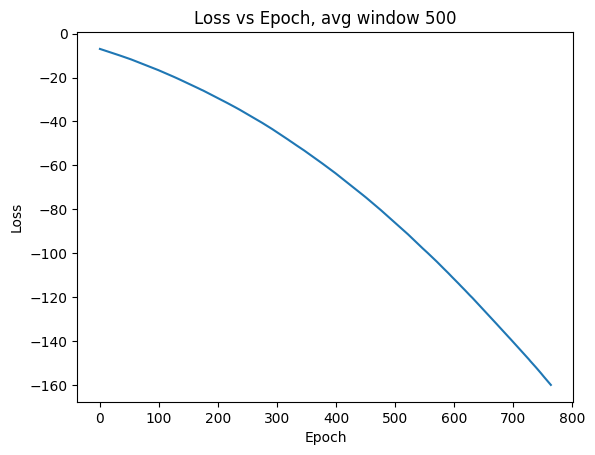

In [ ]:
# Plot the losses
window_size = min(500, len(losses) // 2)
avg = np.convolve(losses, np.ones(window_size), 'valid') / window_size
plt.plot(avg)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss vs Epoch, avg window {window_size}')
plt.show()

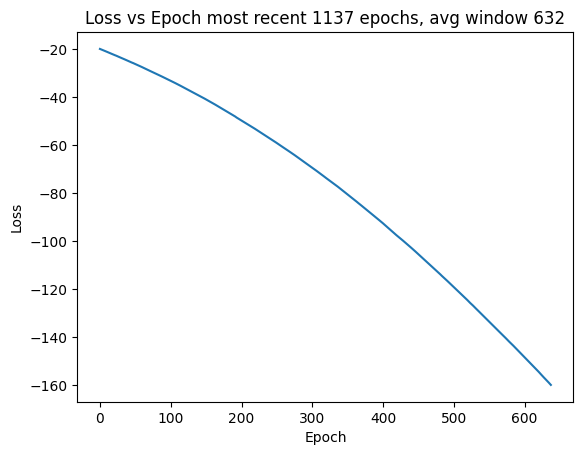

In [ ]:
# Plot the losses of some recent epochs
# window_size_r = 1000
window_size_r = min(1000, len(losses) // 2)
# epochs_r = 10000
epochs_r = min(10000, int(len(losses) * 0.9))
avg = np.convolve(losses[-epochs_r:], np.ones(window_size), 'valid') / window_size
plt.plot(avg)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss vs Epoch most recent {epochs_r} epochs, avg window {window_size_r}')
plt.show()

In [ ]:
dolly_test_0 = dolly[0]
instruction, context, response = dolly_test_0["instruction"], dolly_test_0["context"], dolly_test_0["response"]
crf = crf.eval()
hr_ins = vocab.decode(instruction.tolist())
hr_context = vocab.decode(context.tolist())
instruction = instruction.to(device)
context = context.to(device)
# pad instruction to question_len
instruction = pad(instruction, (0, question_len - len(instruction)), value=pad_idx)

# pad context to context_len
context = pad(context, (0, context_len - len(context)), value=pad_idx)
batched_instruction = instruction.unsqueeze(0)
batched_context = context.unsqueeze(0)
_, tokens = crf.inference(batched_instruction, batched_context)
tokens = tokens[0]
tokens = tokens.to('cpu')

In [ ]:
print(f"Instruction: {hr_ins}")
print(f"Context: {hr_context}")
print(f"Expected Response: {vocab.decode(response.tolist())}")
print(f"Generated Response: {vocab.decode(tokens.tolist())}")

Instruction: When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.
Expected Response: Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.
Generated Response: thedolkenke kom ea,anikenke kom ea,lsn kom ea,lsn kom ea,lsn kom ea,ls kom ea,anikenke kom ea,anikenke kom ea,anikenke kom ea,anikenke kom ea,lsn kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 40 kom ea, 406toto
